In [296]:
!pip install linearmodels
!pip install matplotlib
!pip install seaborn
!pip install sklearn

Initialize data

In [297]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import warnings
warnings.filterwarnings('ignore')

In [298]:
dataset=pd.read_csv('./healthcare-dataset-stroke-data.csv')
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


General information

In [299]:
#Dimesionality check
dataset.shape

(5110, 12)

In [300]:
#check if any empty values
dataset.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [301]:
dataset.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [302]:
# offers a nice overview over the data
# from here we can see the following:
#  average age is 43, glucose level ~ 100, which is considered healthy, most patients do not suffer from heart disease or hypertension

dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Data cleansing

In [303]:
#we have some null values in bmi column
#let's see if there are any stroke records with null values
print(dataset[dataset['bmi'].isna()]['stroke'].count())
dataset[dataset['bmi'].isna()]

201


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [304]:
dataset["bmi"] = pd.to_numeric(dataset["bmi"])
dataset["bmi"] = dataset["bmi"].apply(lambda x: 40 if x>40 else x)

In [305]:
#in order to keep the important data, we will fill nan values with the mean of the column
mean_bmi = dataset['bmi'].mean()
dataset.fillna(mean_bmi, inplace=True)

In [306]:
dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.403707,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,6.507336,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,40.000000,1.000000


Visualizing data

Text(0, 0.5, 'Count of patients')

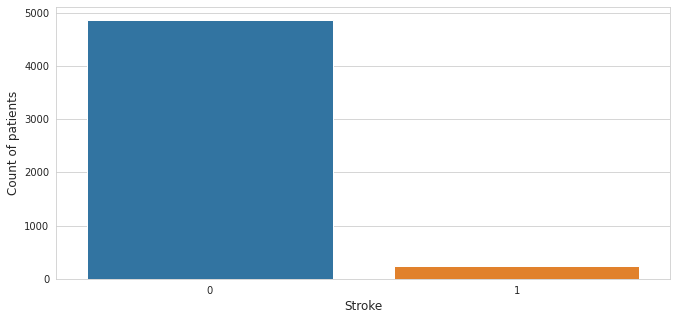

In [307]:
#stroke vs not
sns_plot = sns.countplot(dataset['stroke'])
sns_plot.set_xlabel('Stroke', fontsize=12)
sns_plot.set_ylabel('Count of patients', fontsize=12)

Yes    3353
No     1757
Name: ever_married, dtype: int64


<AxesSubplot:xlabel='ever_married', ylabel='count'>

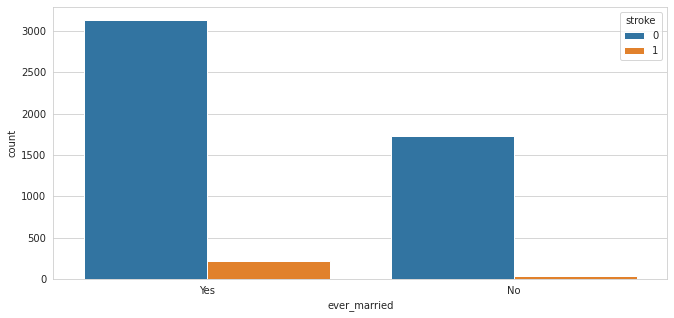

In [308]:
print(dataset['ever_married'].value_counts())
sns.countplot(dataset['ever_married'], hue= dataset['stroke'])

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Text(0, 0.5, 'Count of Patients')

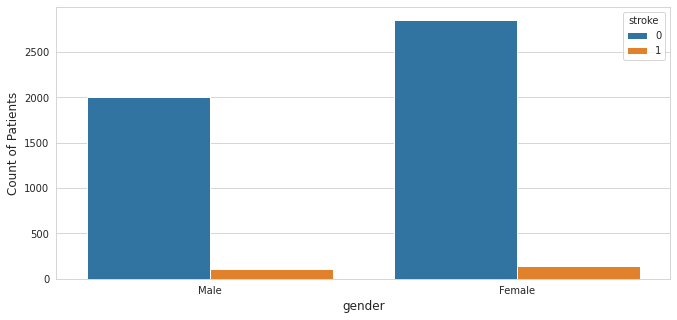

In [309]:
print(dataset['gender'].value_counts())
dataset['gender'] = dataset['gender'].replace('Other', list(dataset.gender.mode().values)[0])
sns_plot = sns.countplot(dataset['gender'], hue = dataset['stroke'])
sns_plot.set_xlabel("gender",fontsize=12)
sns_plot.set_ylabel("Count of Patients",fontsize=12)

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


<AxesSubplot:xlabel='work_type', ylabel='count'>

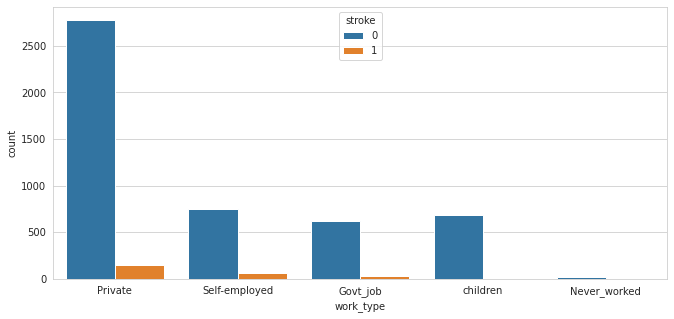

In [310]:
print(dataset['work_type'].value_counts())
sns.countplot(dataset['work_type'], hue = dataset['stroke'])

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


<AxesSubplot:xlabel='smoking_status', ylabel='count'>

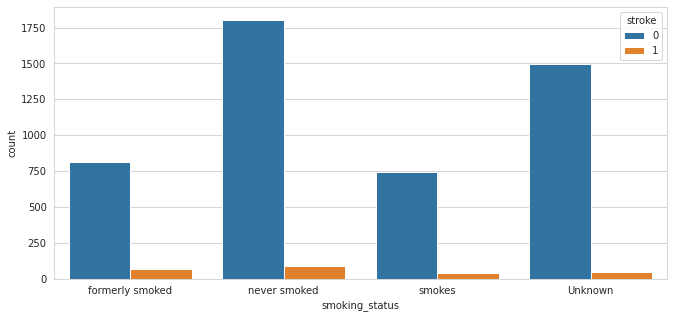

In [311]:
print(dataset['smoking_status'].value_counts())
sns.countplot(dataset['smoking_status'], hue = dataset['stroke'])

0    4612
1     498
Name: hypertension, dtype: int64


Text(0, 0.5, 'Count of Patient')

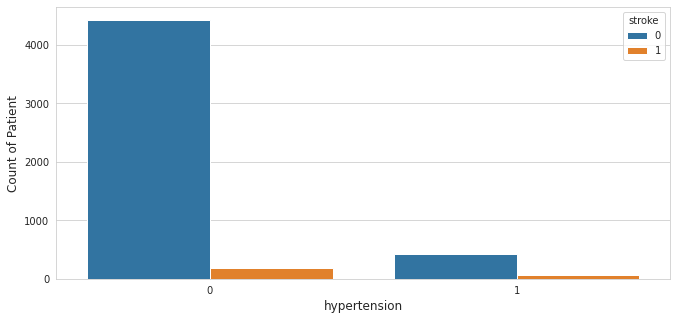

In [312]:
print(dataset['hypertension'].value_counts())
sns_plot = sns.countplot(dataset['hypertension'], hue = dataset['stroke'])
sns_plot.set_xlabel("hypertension",fontsize=12)
sns_plot.set_ylabel("Count of Patient",fontsize=12)

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


Text(0, 0.5, 'Count of Patient')

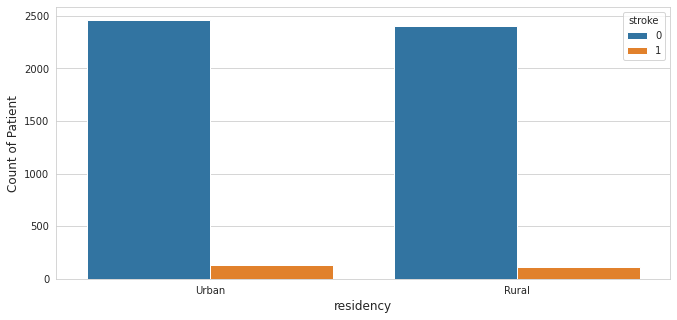

In [313]:
print(dataset['Residence_type'].value_counts())
sns_plot = sns.countplot(dataset['Residence_type'], hue = dataset['stroke'])
sns_plot.set_xlabel("residency",fontsize=12)
sns_plot.set_ylabel("Count of Patient",fontsize=12)

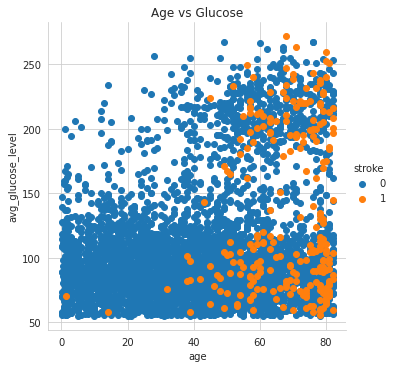

In [314]:
sns.set_style("whitegrid")
sns.FacetGrid(dataset, hue="stroke", height=5).map(plt.scatter, "age", "avg_glucose_level").add_legend()
plt.title('Age vs Glucose')
plt.show()

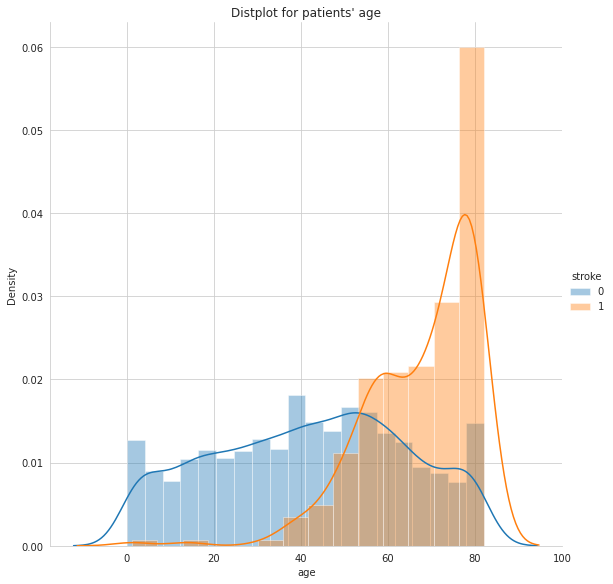

In [315]:
sns.FacetGrid(dataset, hue="stroke", height = 8).map(sns.distplot, "age").add_legend()
plt.title("Distplot for patients' age")
plt.show()

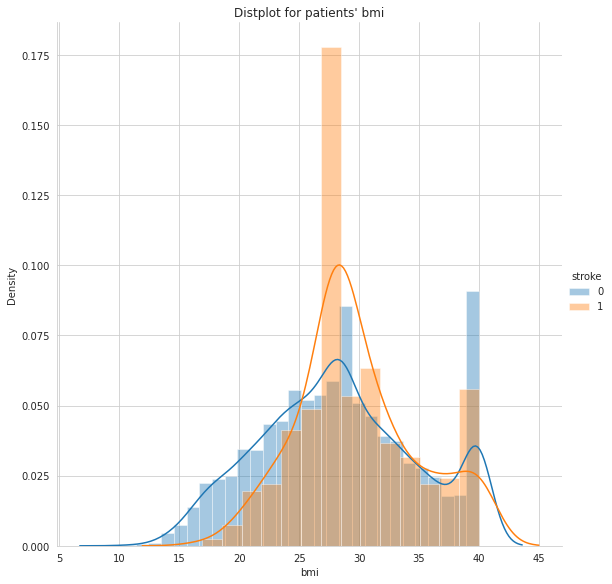

In [316]:
sns.FacetGrid(dataset, hue="stroke", height = 8).map(sns.distplot, "bmi").add_legend()
plt.title("Distplot for patients' bmi")
plt.show()

In [317]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

dataset['gender'] = le.fit_transform(dataset['gender'])
dataset['ever_married'] = le.fit_transform(dataset['ever_married'])
dataset['work_type'] = le.fit_transform(dataset['work_type'])
dataset['Residence_type'] = le.fit_transform(dataset['Residence_type'])
dataset['smoking_status'] = le.fit_transform(dataset['smoking_status'])

dataset.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.403707,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


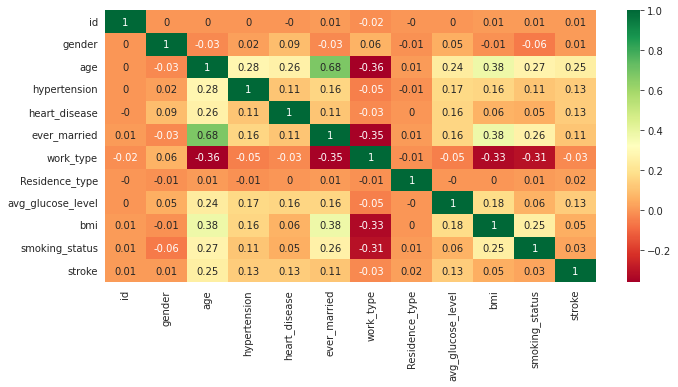

In [318]:
corr = dataset.corr().round(2)
sns.heatmap(corr, annot = True, cmap = 'RdYlGn');

In [319]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

col_scaled = s.fit_transform(dataset[['avg_glucose_level','bmi','age','Residence_type','work_type']])
col_scaled = pd.DataFrame(col_scaled,columns=['avg_glucose_level','bmi','age','Residence_type','work_type'])

dataset_new=dataset.drop(columns=['avg_glucose_level','bmi','age','Residence_type','work_type'],axis=1)
col_scaled.head()

,avg_glucose_level,bmi,age,Residence_type,work_type
0,2.706375,1.259670,1.051434,0.984080,-0.153836
1,2.121559,0.000000,0.786070,-1.016178,0.763438
2,-0.005028,0.629550,1.626390,-1.016178,-0.153836
3,1.437358,0.921557,0.255342,0.984080,-0.153836
4,1.501184,-0.676796,1.582163,-1.016178,0.763438


In [320]:
dataset = pd.concat([dataset_new, col_scaled], axis=1)
dataset = dataset.drop(columns=['ever_married', 'id'], axis=1)
dataset.head(3)

,gender,hypertension,heart_disease,smoking_status,stroke,avg_glucose_level,bmi,age,Residence_type,work_type
0,1,0,1,1,1,2.706375,1.25967,1.051434,0.984080,-0.153836
1,0,0,0,2,1,2.121559,0.00000,0.786070,-1.016178,0.763438
2,1,0,1,2,1,-0.005028,0.62955,1.626390,-1.016178,-0.153836


In [325]:
# Models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

src=dataset.drop(['stroke'], axis=1)
trg=dataset['stroke']
src_train, src_test, trg_train, trg_test = train_test_split(src, trg, test_size=0.3, random_state= 124)

In [326]:
models = dict()
models['Logisticreg'] = LogisticRegression()
models['DecisionTree'] = DecisionTreeClassifier()
models['kNN'] = KNeighborsClassifier()
models['NaiveBayes'] = GaussianNB()
models['SupportVectorMachine'] = SVC(kernel = 'sigmoid', gamma='scale')
models['RandomForest'] = RandomForestClassifier()
models['KMeans'] = KMeans(n_clusters=2, n_init=10, random_state=42)
for model in models:
    
    models[model].fit(src_train, trg_train)
    print(model + " model prepare completed.")

Logisticreg model prepare completed.
DecisionTree model prepare completed.
kNN model prepare completed.
NaiveBayes model prepare completed.
SupportVectorMachine model prepare completed.
RandomForest model prepare completed.
KMeans model prepare completed.


In [327]:
for x in models:

    print('-'*30+x+'-'*30)
    model = models[x]
    y_pred = model.predict(src_test)
    arg_test = {'y_true':trg_test, 'y_pred':y_pred}
    print(confusion_matrix(**arg_test))
    print(classification_report(**arg_test))

------------------------------Logisticreg------------------------------
[[1464    0]
 [  69    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1464
           1       0.00      0.00      0.00        69

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.91      0.95      0.93      1533

------------------------------DecisionTree------------------------------
[[1388   76]
 [  57   12]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1464
           1       0.14      0.17      0.15        69

    accuracy                           0.91      1533
   macro avg       0.55      0.56      0.55      1533
weighted avg       0.92      0.91      0.92      1533

------------------------------kNN------------------------------
[[1453   11]
 [  66    3]]
              precision    recall  f1-score   support

 

In [324]:
print('Summary\n')
for i in models:
    model = models[i]
    print(i + ' Model: ',accuracy_score(trg_test, model.predict(src_test)).round(5))

Summary

Logisticreg Model:  0.95303
DecisionTree Model:  0.90672
kNN Model:  0.94847
NaiveBayes Model:  0.87867
SupportVectorMachine Model:  0.92237
RandomForest Model:  0.95238
KMeans Model:  0.75147


In [330]:
from sklearn.model_selection import cross_val_score

gnb = GaussianNB()

cross_scores = cross_val_score(gnb, src_train, trg_train, cv = 100, scoring='accuracy')
print('Cross validation scores:{}'.format(cross_scores))
print('Mean is {}'.format(cross_scores.mean()))

Cross validation scores:[0.86111111 0.86111111 0.80555556 0.91666667 0.97222222 0.80555556
 0.88888889 0.97222222 0.91666667 0.83333333 0.80555556 0.83333333
 0.88888889 0.83333333 0.83333333 0.91666667 0.86111111 0.83333333
 0.88888889 0.80555556 0.94444444 0.88888889 0.88888889 0.91666667
 0.80555556 0.91666667 0.86111111 0.86111111 0.88888889 0.83333333
 0.83333333 0.83333333 0.86111111 0.88888889 0.86111111 1.
 0.83333333 0.83333333 0.94444444 0.88888889 0.77777778 0.91666667
 0.94444444 0.88888889 0.91666667 0.80555556 0.97222222 0.91666667
 0.86111111 0.88888889 0.83333333 0.88888889 0.94444444 0.94444444
 0.80555556 0.88888889 0.86111111 0.91666667 0.83333333 0.94444444
 0.83333333 0.83333333 0.88888889 0.94444444 0.86111111 0.88888889
 0.77777778 0.83333333 0.91666667 0.86111111 0.88888889 0.83333333
 0.86111111 0.77777778 0.83333333 0.88888889 0.88888889 0.88571429
 0.91428571 0.85714286 0.82857143 0.82857143 0.97142857 0.82857143
 0.85714286 0.88571429 0.94285714 0.94285714 0